In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #,1,2,3"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# Data Generator

In [3]:
class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, batch_size=8, dim=(256,512), n_channels=3, shuffle=True, num_crops=4):

        self.npz_file_IDs = npz_file_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.int16)
        labels = np.empty((self.batch_size, *self.dim), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.dim), dtype=np.int16)

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)
            
            images[i] = npz_data['image_colors'].astype(int)
            # labels[i] = npz_data['points_3d_world']
            
            data_dir = "/".join(ID.split('/')[:-1])
            ind = ID.split('/')[-1].split('_')[0]
            coord_class_file_name = f"/{ind}_simple_region_class.npy"
            labels[i] = np.load(data_dir + coord_class_file_name)

            mask_file_name = f"/{ind}_mask.npy"
            masks[i] = np.load(data_dir + mask_file_name)

        return images, labels, masks

    
    def get_image_crops(self, images, labels, masks):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        image_crops = np.zeros((self.batch_size, 224, 224, self.n_channels), dtype=np.int16)
        label_crops = np.zeros((self.batch_size, 224, 224), dtype=np.float32)
        mask_crops = np.zeros((self.batch_size, 224, 224), dtype=np.float32)

        # pick the start cordinates of croped images
        start_row = np.random.randint(0, high=self.dim[0]-224, size=self.batch_size)
        start_col = np.random.randint(0, high=self.dim[1], size=self.batch_size)

        # get all pixels that span 224 to the right and down from start pixels
        for ind in range(self.batch_size):

            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_image = images[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                wraped_label = labels[ind, start_row[ind]:start_row[ind]+224, :dif]
                wraped_mask = masks[ind, start_row[ind]:start_row[ind]+224, :dif]
                
                image_crops[ind] = np.concatenate(
                    (images[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_image), axis=1)
                label_crops[ind] = np.concatenate(
                    (labels[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224], 
                        wraped_label), axis=1)
                mask_crops[ind] = np.concatenate(
                    (masks[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224], 
                        wraped_mask), axis=1)
            else:
                image_crops[ind] = images[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]
                label_crops[ind] = labels[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224]
                mask_crops[ind] = masks[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224]


        return image_crops, label_crops, mask_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
     
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

        # load images (from a downsampled dataset)
        images, labels, mask = self.load_data(list_IDs_temp)
        
        # crop
        images, labels, mask = self.get_image_crops(images, labels, mask)
        mask = np.expand_dims(mask, axis=-1)
    
        # one-hot encode labels
        labels = (np.arange(labels.max()+1) == labels[...,None]).astype(int)

        # coccatenate to images
        labels = np.concatenate((labels, mask), axis=-1)

        return images, labels

In [4]:
generator_configs = {'batch_size': 1, 
                     'dim': (256,512), 
                     'n_channels': 3, 
                     'shuffle': True, 
                     'num_crops': 1}

data_partition = ["/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_full/0268_rendered.png_config.npz"]

train_generator = DataGenerator(data_partition, **generator_configs)

# Model

In [5]:
from tensorflow.keras import layers

def vgg_encoder(input_shape=(224, 224, 3)):
    
    image_input = layers.Input(shape=(224, 224, 3))

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    f3 = x

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    f4 = x

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    f5 = x
    
    return image_input, [f1,f2,f3,f4,f5]

In [6]:
from tensorflow.keras.models import Model

def vgg_unet(input_height=224, input_width=224):

    model = unet(vgg_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "vgg_unet"
    
    return model


def unet(encoder, l1_skip_conn=True, input_height=224,
          input_width=224):

    image_input = layers.Input(shape=(224, 224, 3))
    
    image_input, levels = encoder(image_input)
    [f1, f2, f3, f4, f5] = levels

    o = f4
    o = (layers.ZeroPadding2D((1, 1), name='U_block1_zero_pad'))(o)
    o = (layers.Conv2D(512, (3, 3), padding='valid' , activation='relu', name='U_block1_conv'))(o)
    o = (layers.BatchNormalization(name='U_block1_batch_norm'))(o)

    o = (layers.UpSampling2D((2, 2), name='U_block2_up_sample'))(o)
    o = (layers.concatenate([o, f3], axis=-1, name='U_block2_concat'))
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(512, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = (layers.UpSampling2D((2, 2)))(o)
    o = (layers.concatenate([o, f2], axis=-1))
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(256, (3, 3), padding='valid' , activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = (layers.UpSampling2D((2, 2)))(o)

    if l1_skip_conn:
        o = (layers.concatenate([o, f1], axis=-1))

    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = layers.Conv2D(128, (3, 3), padding='same')(o)
    
    o = (layers.UpSampling2D((2, 2)))(o)
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)
    
    o = layers.Conv2D(64, (3, 3), padding='same')(o)
    # 3D SCENE COORD - REGRESSION    
    # output = layers.Conv2D(3, (3, 3), padding='same')(o)

    # CLASSIFICATION
    o = layers.Conv2D(8, (3, 3), padding='same')(o)
    output = keras.activations.softmax(o, axis=-1)
        
    model = Model(inputs=image_input, outputs=output) 
#     model.summary()
    
    return model

# Loss func

In [44]:
def masked_X_entropy(y_true, y_pred):
    " masked CrossEntropy - used for classification of regions "

    mask = y_true[:,:,:,-1]
    y_true = y_true[:,:,:,:8]

    nested_masks = [mask for _ in range(8)]
    mask_expanded = tf.stack(nested_masks, axis=-1)

#     y_pred = tf.math.multiply(y_pred, mask_expanded) 
#     y_true = tf.math.multiply(y_true, mask_expanded)

    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred) #, from_logits=True)
    return tf.reduce_mean(loss)

# Setup model

In [45]:
# Example model
unet_model = vgg_unet()
unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=masked_X_entropy) #, metrics=[output])

# Fit model

In [46]:
images, labels = train_generator.__getitem__(0)
# images = np.ones((1,224,224,3))
# labels = np.zeros((1,224,224,9))
# labels[:,:,:,0] = 1
# labels[:,:,:,-1] = 1

In [47]:
mask = labels[:,:,:,8]
gt_labels = labels[:,:,:,:8]

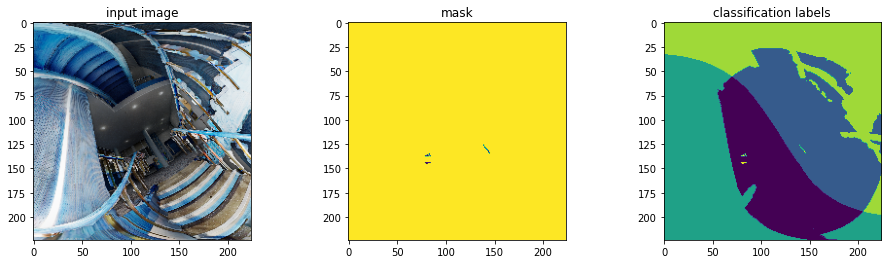

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

ax1.imshow(images[0])
ax1.set_title("input image")
ax2.imshow(mask[0])
ax2.set_title("mask")
ax3.imshow(np.argmax(gt_labels[0], axis=-1))
ax3.set_title("classification labels")
plt.show()

In [49]:
fit_configs = {'epochs': 100, 
               'verbose': 1}

# history = unet_model.fit(x=train_generator,  **fit_configs) #, callbacks=callback
history = unet_model.fit(images, labels,  **fit_configs) #, callbacks=callback

Epoch 1/100
1/1 [==============================] - 0s 12ms/step - loss: 2.7205
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 2.1179
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 1.7294
Epoch 4/100
1/1 [==============================] - 0s 13ms/step - loss: 1.4636
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 1.2605
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 1.0840
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9278
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.7955
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6801
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5798
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4921
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4161
Epoch 13/100
1/1 [==============================] 

In [29]:
extractor = keras.Model(inputs=unet_model.inputs,
                        outputs=[unet_model.output for layer in unet_model.layers])

In [30]:
output = extractor(images)

In [31]:
output[-1].numpy()[0,0,0,:]

array([0.09101458, 0.06661325, 0.10857932, 0.07262439, 0.03084323,
       0.07310657, 0.49807948, 0.05913912], dtype=float32)

# Evaluate model

In [32]:
labelpred = unet_model.predict(images)

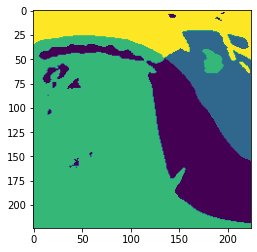

In [33]:
plt.imshow(np.argmax(labelpred[0], axis=-1))

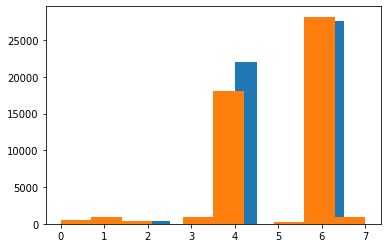

In [29]:
plt.figure()
plt.hist(np.argmax(gen_labels[0], axis=-1).flatten())
plt.hist(np.argmax(labelpred[0], axis=-1).flatten())
plt.show()

# Debugging code

In [55]:
gen_mask_ = np.expand_dims(gen_mask, axis=-1)
gen_mask_.shape

(1, 224, 224, 1)

In [71]:
labels_pred = np.zeros((1,224,224,8))
labels_pred[:,:,:,:] = 1/8

labels_true = np.zeros((1,224,224,8))
labels_true[:,:,:,0] = 1
# mask = np.ones((1,224,224,1))
labels_true = np.concatenate([labels_true, gen_mask_], axis=-1)
labels_true.shape

(1, 224, 224, 9)

In [72]:
a = masked_X_entropy(labels_true, labels_pred)
a.numpy()

tf.Tensor(
[[[2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  ...
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]]], shape=(1, 224, 224), dtype=float64)


array([[[2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        ...,
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154]]])

In [73]:
np.unique(a.numpy())

array([0.        , 2.07944154])

(array([2.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0152e+04]),
 array([0.        , 0.20794415, 0.41588831, 0.62383246, 0.83177662,
        1.03972077, 1.24766493, 1.45560908, 1.66355323, 1.87149739,
        2.07944154]),
 <BarContainer object of 10 artists>)

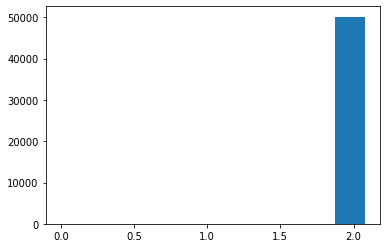

In [74]:
plt.hist(a.numpy().flatten())

In [18]:
tf.keras.losses.categorical_crossentropy(labels_pred, labels_true[:,:,:,:8])

<tf.Tensor: shape=(1, 224, 224), dtype=float64, numpy=
array([[[14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        ...,
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371]]])>

## $\color{red}{\text{CONCLUSION:}}$
### there were 3 errors:

**1. cross entropy outputed 2D matrix rather than scalar** Loss in general should be a scalar. If it's a vector you might compute an update with respect to each element of loss which could grow quicker than for a mean. There would be batch_size*224*224 updates

**2. I was applying softmax function twice** After deleting the first softmax model was fixed. The first softmax could be applied for all nodes 224x224x8 rather than just along the axis=-1

**3. there is some issue with the way i apply the mask** 